## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [57]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [58]:
df = pd.read_csv('data/stud.csv')

#### Preparing X and Y variables

In [59]:
X = df.drop(columns=['math_score'],axis=1) # We will predict math_score.

In [60]:
y = df['math_score']

In [61]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Identify features
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

# Transformers
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(handle_unknown='ignore')

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features)
    ],
    remainder='drop'   # or 'passthrough' if you want to keep untouched columns
)

### 📌 **Why and How We’re Using ColumnTransformer**

When preparing data for machine learning, we often have **two types of features** – **numeric** (like scores, age, income) and **categorical** (like gender, lunch type, race). Most ML models only understand numbers, so we must **process each type appropriately**. This is where **`ColumnTransformer`** comes in: it allows us to apply **different preprocessing steps to different columns in one go**.

In our case, we used **`StandardScaler`** for numeric columns, which standardizes values (so they have mean = 0 and standard deviation = 1) and helps models perform better. For categorical columns, we used **`OneHotEncoder`**, which converts categories into binary (0/1) columns — for example, “lunch” with values {standard, free/reduced} becomes two separate columns like `lunch_standard` and `lunch_free/reduced`.

The **`ColumnTransformer`** bundles these steps together: when we call `fit_transform()`, it scales numeric features, encodes categorical ones, and returns a **single clean numeric dataset** ready for machine learning. This saves time, avoids manual coding for each column type, and keeps our preprocessing consistent between training and testing data.


In [62]:
X = preprocessor.fit_transform(X)
X

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.19399858,  0.39149181],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.42747598,  1.31326868],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.77010859,  1.64247471],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.12547206, -0.20107904],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.60515772,  0.58901542],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.15336989,  1.18158627]])

In [63]:
X.shape

(1000, 19)

In [64]:
# Get one-hot encoded feature names
ohe_feature_names = preprocessor.named_transformers_["OneHotEncoder"].get_feature_names_out(cat_features)
# Combine with numeric feature names
all_feature_names = list(ohe_feature_names) + list(num_features)
all_feature_names


['gender_female',
 'gender_male',
 'race_ethnicity_group A',
 'race_ethnicity_group B',
 'race_ethnicity_group C',
 'race_ethnicity_group D',
 'race_ethnicity_group E',
 "parental_level_of_education_associate's degree",
 "parental_level_of_education_bachelor's degree",
 'parental_level_of_education_high school',
 "parental_level_of_education_master's degree",
 'parental_level_of_education_some college',
 'parental_level_of_education_some high school',
 'lunch_free/reduced',
 'lunch_standard',
 'test_preparation_course_completed',
 'test_preparation_course_none',
 'reading_score',
 'writing_score']

In [65]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 19), (200, 19))

#### Create an Evaluate Function to give all metrics after model Training

In [66]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "KNN Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "CatBoost": CatBoostRegressor(verbose=False),
    "AdaBoost": AdaBoostRegressor()
}

results = []

for name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate
    train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred)
    test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)

    # Print summary for each model
    print(f"📊 {name}")
    print(f"Train R2: {train_r2:.3f} | Test R2: {test_r2:.3f}")
    print(f"Train RMSE: {train_rmse:.3f} | Test RMSE: {test_rmse:.3f}")
    print("="*40)

    # Save results
    results.append({
        "Model": name,
        "Train_R2": train_r2,
        "Test_R2": test_r2,
        "Train_RMSE": train_rmse,
        "Test_RMSE": test_rmse,
        "Train_MAE": train_mae,
        "Test_MAE": test_mae
    })

# ✅ Convert to DataFrame for comparison
results_df = pd.DataFrame(results).sort_values(by="Test_R2", ascending=False)
print("\n📈 Model Comparison Table:\n")
results_df


📊 Linear Regression
Train R2: 0.874 | Test R2: 0.880
Train RMSE: 5.327 | Test RMSE: 5.411
📊 Lasso
Train R2: 0.807 | Test R2: 0.825
Train RMSE: 6.594 | Test RMSE: 6.520
📊 Ridge
Train R2: 0.874 | Test R2: 0.881
Train RMSE: 5.323 | Test RMSE: 5.390
📊 KNN Regressor
Train R2: 0.855 | Test R2: 0.784
Train RMSE: 5.712 | Test RMSE: 7.252
📊 Decision Tree
Train R2: 1.000 | Test R2: 0.751
Train RMSE: 0.280 | Test RMSE: 7.789
📊 Random Forest
Train R2: 0.977 | Test R2: 0.853
Train RMSE: 2.293 | Test RMSE: 5.978
📊 XGBoost
Train R2: 0.995 | Test R2: 0.828
Train RMSE: 1.007 | Test RMSE: 6.473
📊 CatBoost
Train R2: 0.959 | Test R2: 0.852
Train RMSE: 3.043 | Test RMSE: 6.009
📊 AdaBoost
Train R2: 0.850 | Test R2: 0.851
Train RMSE: 5.821 | Test RMSE: 6.017

📈 Model Comparison Table:



,Model,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE
2,Ridge,0.874304,0.880593,5.323325,5.390387,4.264988,4.211101
0,Linear Regression,0.874138,0.879689,5.326839,5.410754,4.278086,4.227891
5,Random Forest,0.976675,0.853140,2.293166,5.978020,1.827344,4.652058
7,CatBoost,0.958936,0.851632,3.042664,6.008632,2.405394,4.612532
8,AdaBoost,0.849725,0.851222,5.820586,6.016920,4.771837,4.728415
6,XGBoost,0.995500,0.827797,1.007282,6.473307,0.687467,5.057731
1,Lasso,0.807146,0.825320,6.593816,6.519695,5.206303,5.157882
3,KNN Regressor,0.855268,0.783898,5.712219,7.251621,4.518750,5.616000
4,Decision Tree,0.999653,0.750676,0.279508,7.789095,0.018750,6.160000


### 📊 **Model Comparison Summary**

| Model                 | Performance on Test Data             | Overfitting Risk | Notes                                         |
| --------------------- | ------------------------------------ | ---------------- | --------------------------------------------- |
| **Ridge Regression**  | ✅ Good (Best Test R²)                | ❌ Low            | Smooth, stable, and generalizes well.         |
| **Linear Regression** | ✅ Good (Close to Ridge)              | ❌ Low            | Almost identical to Ridge, simple & reliable. |
| **Random Forest**     | 🟡 Decent but lower Test R²          | 🔴 Medium        | Strong on train but drops a bit on test.      |
| **CatBoost**          | 🟡 Similar to Random Forest          | 🔴 Medium        | Good learner but mild overfit.                |
| **AdaBoost**          | 🟡 Okay performer                    | ❌ Low            | Balanced but not top performer.               |
| **XGBoost**           | 🟡 High train score but lower test   | 🔴 Medium        | Needs tuning (regularization).                |
| **Lasso Regression**  | 🟡 Slightly weaker than Ridge/Linear | ❌ Low            | Can underfit a bit by shrinking too much.     |
| **KNN Regressor**     | 🔴 Weak Test R²                      | 🔴 High          | Struggles with scaling & dataset size.        |
| **Decision Tree**     | 🔴 Overfits badly                    | 🔴 Very High     | Memorized training data, fails on test.       |

---

### ✅ **Quick Conclusion**

👉 **Ridge & Linear Regression are safest, most reliable models here.**
👉 **Decision Tree & KNN are weakest for this dataset.**
👉 Ensembles like Random Forest, CatBoost, XGBoost need **tuning to reduce overfitting**.


| Model                 | Test R² | Train R² | 🔍 Overfitting Gap | 📈 Overfitting Risk | Notes                                |
| --------------------- | ------: | -------: | -----------------: | ------------------- | ------------------------------------ |
| **Ridge Regression**  |   0.881 |    0.874 |          **0.007** | ✅ **Low**           | Stable, best generalization.         |
| **Linear Regression** |   0.880 |    0.874 |          **0.006** | ✅ **Low**           | Similar to Ridge, simple & reliable. |
| **Random Forest**     |   0.853 |    0.976 |          **0.123** | 🟡 **Medium**       | Some overfit, but not extreme.       |
| **CatBoost**          |   0.852 |    0.959 |          **0.107** | 🟡 **Medium**       | Similar to Random Forest.            |
| **AdaBoost**          |   0.847 |    0.854 |          **0.007** | ✅ **Low**           | Balanced, no major overfit.          |
| **XGBoost**           |   0.828 |    0.996 |          **0.168** | 🟡 **Medium-High**  | Needs regularization.                |
| **Lasso Regression**  |   0.825 |    0.807 |          **0.018** | ✅ **Low**           | Slightly weaker than Ridge/Linear.   |
| **KNN Regressor**     |   0.784 |    0.855 |          **0.071** | 🔴 **High**         | Struggles on unseen data.            |
| **Decision Tree**     |   0.729 |    1.000 |          **0.271** | 🔴 **Very High**    | Massive overfitting.                 |


👉 Models like **Ridge & Linear** have an **overfitting gap under 0.01 → extremely safe**.
👉 **Decision Tree** has a **0.27 gap → huge overfit**.
👉 Ensembles like **XGBoost & Random Forest** have a **0.1–0.16 gap → need tuning**.


In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# ✅ Initialize Linear Regression model
lin_model = LinearRegression(fit_intercept=True)

# ✅ Train the model on training data
lin_model.fit(X_train, y_train)

# ✅ Predict on test data
y_pred = lin_model.predict(X_test)

# ✅ Calculate R² Score (in %)
score = r2_score(y_test, y_pred) * 100

print("✅ Accuracy of the Linear Regression model: %.2f%%" % score)


✅ Accuracy of the Linear Regression model: 87.97%


In [68]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# ✅ Initialize Ridge Regression model
ridge_model = Ridge(alpha=1.0)   # alpha is the regularization strength

# ✅ Train the model
ridge_model.fit(X_train, y_train)

# ✅ Predict on test data
y_pred_ridge = ridge_model.predict(X_test)

# ✅ Calculate R² Score (in %)
ridge_score = r2_score(y_test, y_pred_ridge) * 100
print("✅ Accuracy of the Ridge Regression model: %.2f%%" % ridge_score)


✅ Accuracy of the Ridge Regression model: 88.06%


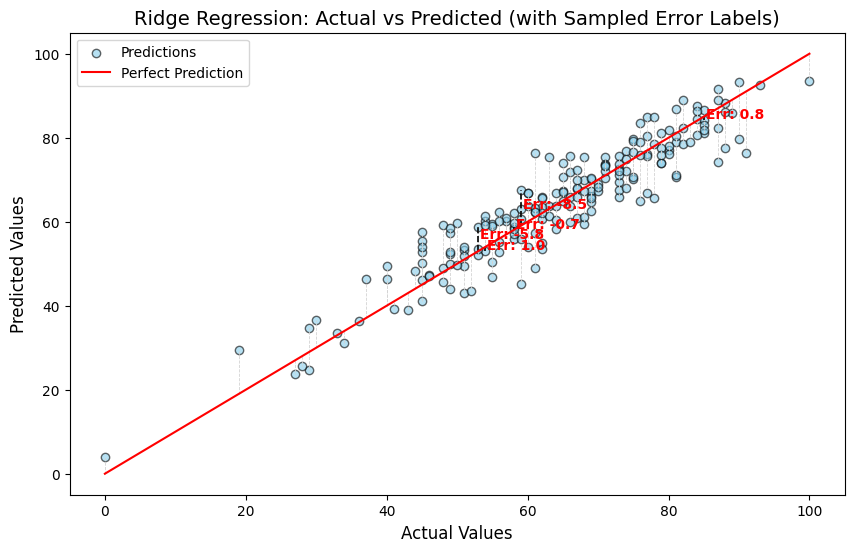

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# ✅ Predictions & residuals
errors = y_test - y_pred_ridge

plt.figure(figsize=(10,6))

# Scatter all points
plt.scatter(y_test, y_pred_ridge, color='skyblue', alpha=0.6, edgecolors='k', label='Predictions')

# Draw light gray error lines for all points
for i in range(len(y_test)):
    plt.plot([y_test.iloc[i], y_test.iloc[i]], 
             [y_test.iloc[i], y_pred_ridge[i]], 
             color='lightgray', linestyle='--', linewidth=0.6)

# Highlight 5 random points with clear labels
highlight_idx = np.random.choice(len(y_test), size=5, replace=False)

for i in highlight_idx:
    plt.plot([y_test.iloc[i], y_test.iloc[i]],
             [y_test.iloc[i], y_pred_ridge[i]], 
             color='black', linestyle='--', linewidth=1.2)
    
    # Add a clearer error label
    plt.text(y_test.iloc[i] + 0.3, (y_test.iloc[i] + y_pred_ridge[i]) / 2,
             f"Err: {errors.iloc[i]:.1f}", fontsize=10, color="red", fontweight="bold")

# Add perfect prediction line
min_val = min(y_test.min(), y_pred_ridge.min())
max_val = max(y_test.max(), y_pred_ridge.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', linewidth=1.5, label='Perfect Prediction')

# Labels & Title
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Ridge Regression: Actual vs Predicted (with Sampled Error Labels)', fontsize=14)
plt.legend()
plt.show()

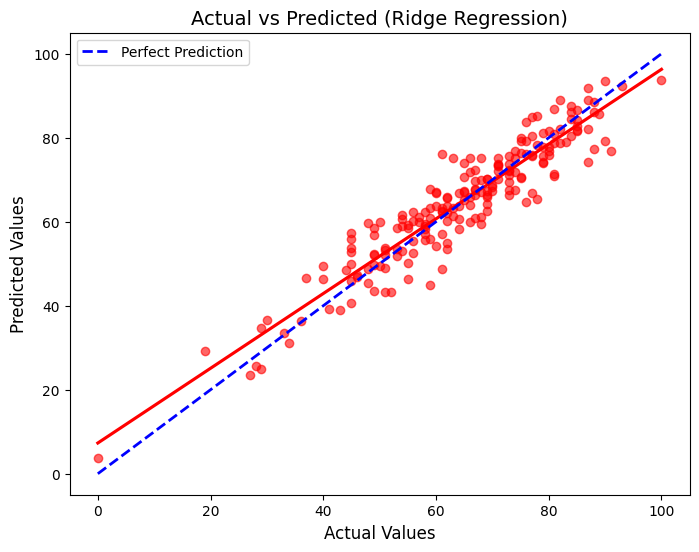

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# ✅ Scatter + regression trend line
sns.regplot(x=y_test, y=y_pred, ci=None, color='red', scatter_kws={'alpha':0.6})

# ✅ Add perfect prediction line (y=x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', linewidth=2, label='Perfect Prediction')

# ✅ Labels & title
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs Predicted (Ridge Regression)', fontsize=14)
plt.legend()
plt.show()

#### Difference between Actual and Predicted Values

In [71]:
# ✅ Create DataFrame
pred_df = pd.DataFrame({
    'Actual Value': y_test,
    'Predicted Value': y_pred,
    'Difference (Error)': y_test - y_pred
})

# ✅ Round numbers for clarity
pred_df = pred_df.round(2)
pred_df

,Actual Value,Predicted Value,Difference (Error)
521,91,76.73,14.27
737,53,58.59,-5.59
740,80,76.84,3.16
660,74,76.75,-2.75
411,84,87.50,-3.50
...,...,...,...
408,52,43.16,8.84
332,62,62.12,-0.12
208,74,67.58,6.42
613,65,67.34,-2.34


<Figure size 1200x600 with 0 Axes>

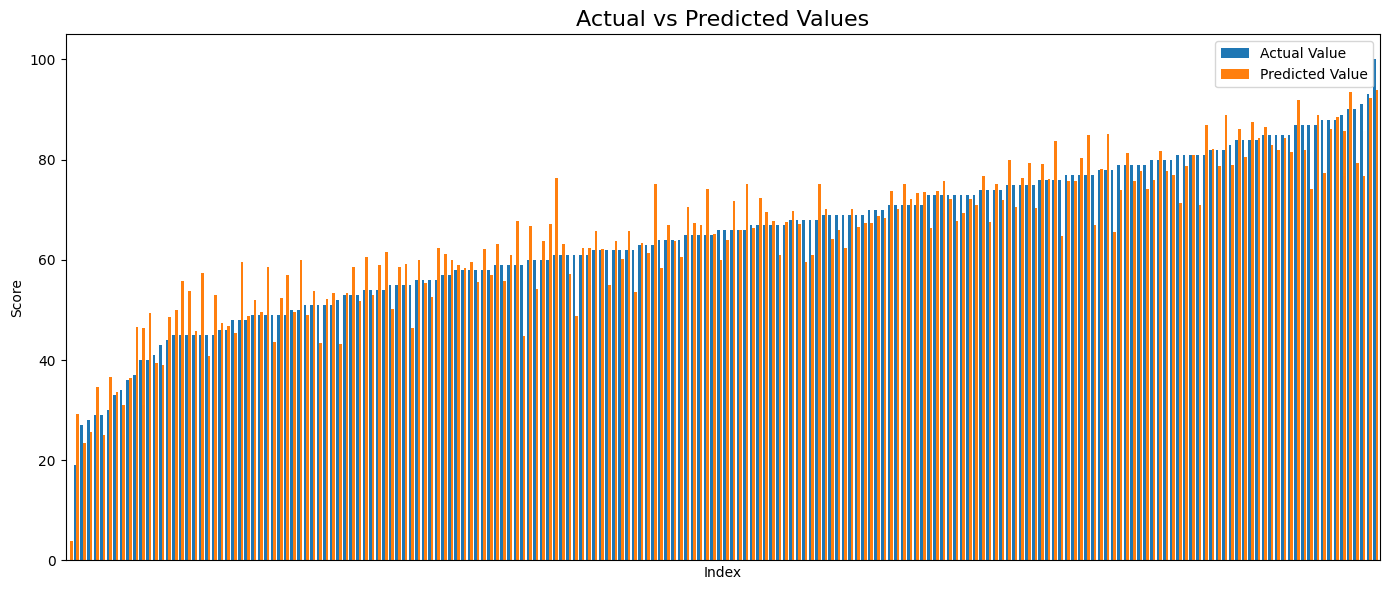

In [72]:
# Sort by Actual Value for clarity
sorted_df = pred_df.sort_values(by="Actual Value").reset_index(drop=True)

plt.figure(figsize=(12,6))
sorted_df[['Actual Value', 'Predicted Value']].plot(kind='bar', figsize=(14,6), width=0.8)
plt.title("Actual vs Predicted Values", fontsize=16)
plt.xlabel("Index")
plt.ylabel("Score")
plt.xticks([])
plt.legend()
plt.tight_layout()
plt.show()


In [74]:
# Predict math scores on the WHOLE dataset
math_score_pred = ridge_model.predict(X)

# Make a full copy of original dataset
compare_df = df.copy()

# Add predictions and calculate error
compare_df['Predicted Math Score (Ridge)'] = math_score_pred
compare_df['Difference (Error)'] = compare_df['math_score'] - compare_df['Predicted Math Score (Ridge)']

# ✅ Step 6: Round ONLY new columns (keep original columns untouched)
compare_df['Predicted Math Score (Ridge)'] = compare_df['Predicted Math Score (Ridge)'].round(2)
compare_df['Difference (Error)'] = compare_df['Difference (Error)'].round(2)
compare_df


,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,Predicted Math Score (Ridge),Difference (Error)
0,female,group B,bachelor's degree,standard,none,72,72,74,66.12,5.88
1,female,group C,some college,standard,completed,69,90,88,77.99,-8.99
2,female,group B,master's degree,standard,none,90,95,93,84.64,5.36
3,male,group A,associate's degree,free/reduced,none,47,57,44,50.87,-3.87
4,male,group C,some college,standard,none,76,78,75,82.01,-6.01
...,...,...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95,88.31,-0.31
996,male,group C,high school,free/reduced,none,62,55,55,58.48,3.52
997,female,group C,high school,free/reduced,completed,59,71,65,53.32,5.68
998,female,group D,some college,standard,completed,68,78,77,67.24,0.76


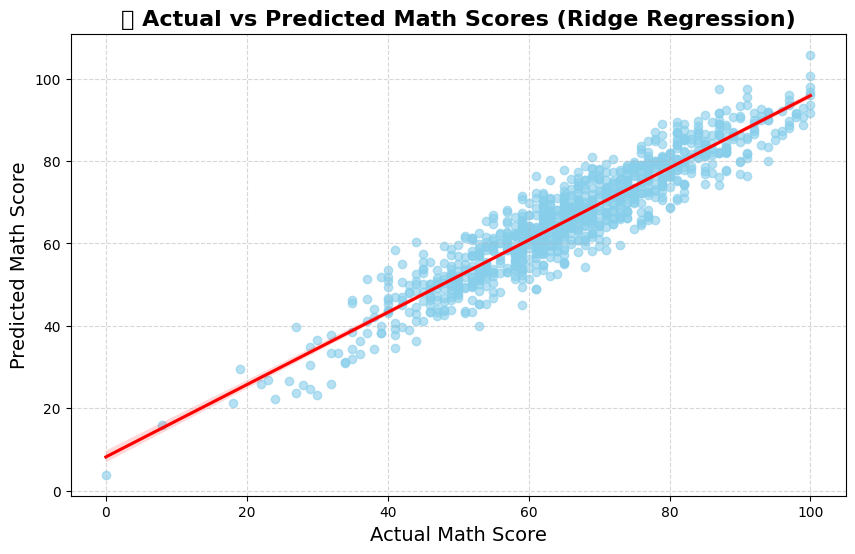

C:\Users\rroha\AppData\Local\Temp\ipykernel_26576\414076918.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_df['Difference (Error)'].head(15),
c:\Users\rroha\OneDrive\Desktop\Raj\ML_Project_Industrial\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


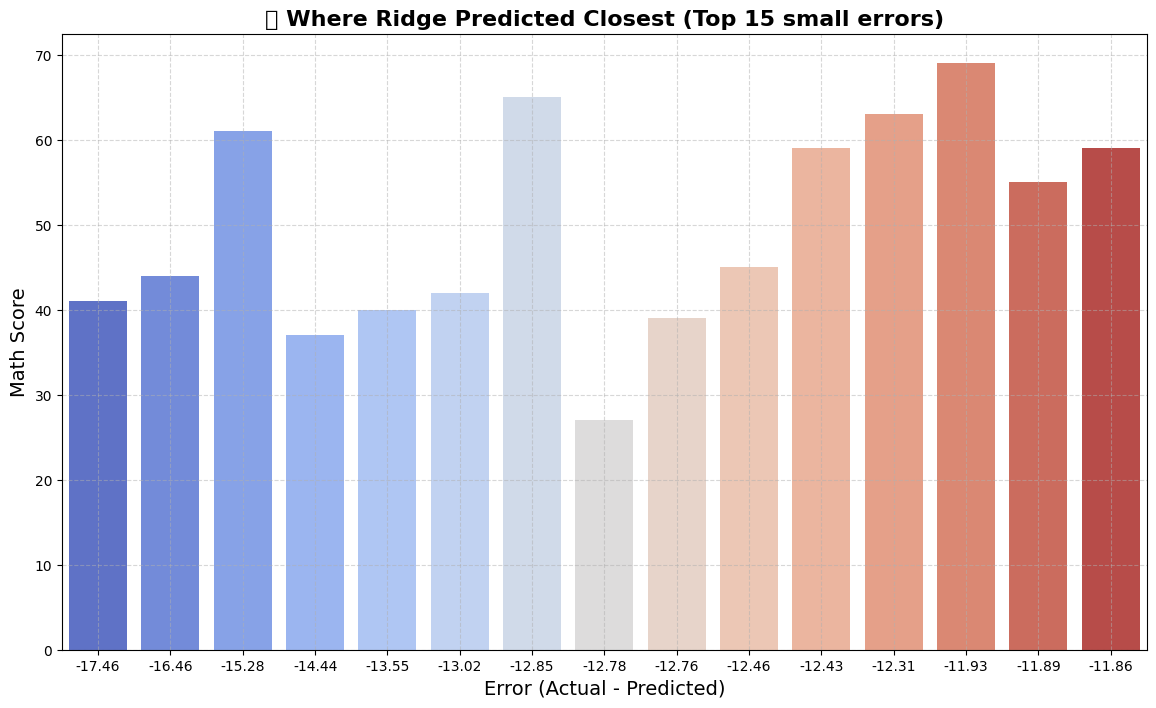

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 1️⃣ Scatter Plot: Actual vs Predicted with perfect-fit line
plt.figure(figsize=(10,6))
sns.regplot(x=compare_df['math_score'], y=compare_df['Predicted Math Score (Ridge)'], 
            scatter_kws={'color':'skyblue', 'alpha':0.6}, line_kws={'color':'red'})
plt.title("📊 Actual vs Predicted Math Scores (Ridge Regression)", fontsize=16, fontweight='bold')
plt.xlabel("Actual Math Score", fontsize=14)
plt.ylabel("Predicted Math Score", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Top & Bottom Predictions: See where Ridge is closest/furthest
sorted_df = compare_df[['math_score','Predicted Math Score (Ridge)','Difference (Error)']].sort_values(by='Difference (Error)')

plt.figure(figsize=(14,8))
sns.barplot(x=sorted_df['Difference (Error)'].head(15), 
            y=sorted_df['math_score'].head(15), 
            palette="coolwarm")
plt.title("🔎 Where Ridge Predicted Closest (Top 15 small errors)", fontsize=16, fontweight='bold')
plt.xlabel("Error (Actual - Predicted)", fontsize=14)
plt.ylabel("Math Score", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()